# Множественное тестирование гипотез

## Библиотеки

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt

import scipy.stats as st
import seaborn as sns

# критерий стюдента для независимых выборок
from  statsmodels.stats.weightstats import ttest_ind

# пакет для проверки множественных гипотез
from statsmodels.stats.multitest import multipletests

## Warmup

### Модельный эксперимент

#### Постановка
**Данные:**

$n=20, \quad m=200, \quad m_0=150$,

$\mathbf{X}_i \sim \mathcal{N}(\mathbf{0}, \mathbf{I}), \quad i=1,\dots,m_0;$

$\mathbf{X}_i \sim \mathcal{N}(\mathbf{1}, \mathbf{I}), \quad i=m_0+1,\dots,m;$

$\mathbf{X}_i \in \mathbb{R}^n.$

**Гипотезы:**

$H^i_0: \mathsf{E}\mathbf{X}_i = 0$;

$H^i_1: \mathsf{E}\mathbf{X}_i \neq 0$;


**Критерий для проверки:**
* одновыборочный t-Критерия Стьюдента.

#### Генерация данных

In [2]:
rs = np.random.RandomState(42)

alpha = 0.05
m = 200
m0 = 150
n = 20

X = rs.randn(m,n)
X[m0:]+=1

#### Гистограммы

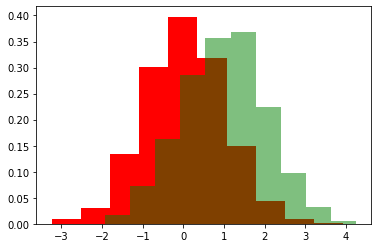

In [5]:
_ = plt.hist(X[:m0].flatten(), color='r', density=True)
_ = plt.hist(X[m0:].flatten(), color='g', alpha=0.5, density=True)

#### Эксперимент

В качестве статистики использовать функцию ```st.ttest_1samp``` из пакета ```scipy.stats```.

##### Без поправок

In [10]:
# zero mean
rejected = 0
for x in X[:m0]:
    if st.ttest_1samp(x, 0)[1] <= alpha:
        rejected+=1

print ('True: H0; H1 non-rejected:', m0 - rejected)
print ('True: H0; H0 rejected:', rejected)

# non-zero mean
rejected = 0
for x in X[m0:]:
    if st.ttest_1samp(x, 0)[1] <= alpha:
        rejected+=1

print ('True: H1; H1 non-rejected:', m-m0 - rejected)
print ('True: H1; H0 rejected:', rejected)

True: H0; H1 non-rejected: 139
True: H0; H0 rejected: 11
True: H1; H1 non-rejected: 0
True: H1; H0 rejected: 50


Ошиблись 11 раз (ошибка 1-го рода), так как вероятность ошибиться равна $0.5^{150} = $

In [15]:
print(0.95**150*100, "%")

0.04555549744836572 %


##### Бонферони (из пакета)

In [18]:
# zero mean
p_values = []
for x in X:
    ### Ваш код тут ###
    p_values.append(st.ttest_1samp(x, 0)[1])

rejections = multipletests(p_values, method='bonferroni')[0]

print ('True: H0; H1 non-rejected:', m0 - rejections[:m0].sum())
print ('True: H0; H1 rejected:',  rejections[:m0].sum())

# non-zero mean
rejections = multipletests(p_values, method='bonferroni')[0]

print ('True: H1;  H1 non-rejected:', m-m0 - rejections[m0:].sum())
print ('True: H1;  H1 rejected:',  rejections[m0:].sum())



True: H0; H1 non-rejected: 150
True: H0; H1 rejected: 0
True: H1;  H1 non-rejected: 30
True: H1;  H1 rejected: 20


##### Бонферони (руками)

In [21]:
# zero mean
rejected = 0
for x in X[:m0]:
    if st.ttest_1samp(x, 0)[1] <= alpha/m:
        rejected+=1

print ('True: H0; H1 non-rejected:', m0 - rejected)
print ('True: H0; H0 rejected:', rejected)

# non-zero mean
rejected = 0
for x in X[m0:]:
    if st.ttest_1samp(x, 0)[1] <= alpha/m:
        rejected+=1

print ('True: H1; H1 non-rejected:', m-m0 - rejected)
print ('True: H1; H0 rejected:', rejected)

True: H0; H1 non-rejected: 150
True: H0; H0 rejected: 0
True: H1; H1 non-rejected: 30
True: H1; H0 rejected: 20


##### График зависимости мощности для разных поправок

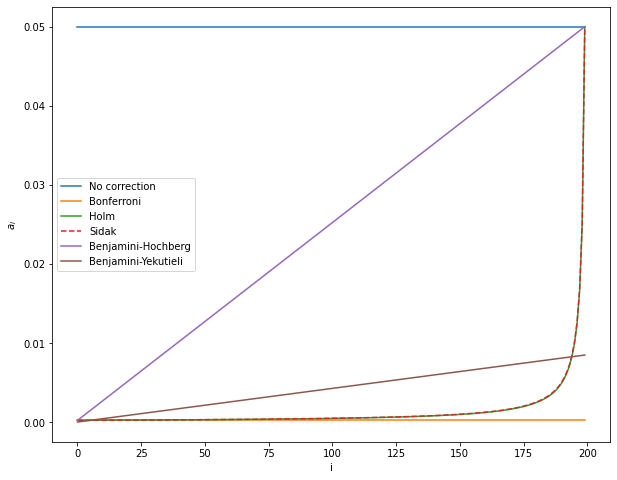

In [30]:
# no correction
plt.plot([0, m - 1], [alpha] * 2, label='No correction')

# bonferroni
bonferroni = alpha / m
plt.plot([0, m - 1], [bonferroni] * 2, label='Bonferroni')

# holm
holm = alpha / np.arange(m, 0, -1)
plt.plot(holm, label='Holm')

# sidak
sidak = 1 - np.power((1. - alpha),  1. / np.arange(m, 0, -1))
plt.plot(sidak, label='Sidak', ls='--')

# benjamini-hochberg
ecdffactor = np.arange(1, m + 1)/float(m)
bh = alpha * ecdffactor
plt.plot(range(m), bh, label='Benjamini-Hochberg' )

# benjamini-yekutieli 
cm = np.sum(1. / np.arange(1, m+1)) 
ecdffactor = ecdffactor / cm
by = alpha * ecdffactor
plt.plot(range(m), by, label='Benjamini-Yekutieli ' )

plt.xlabel('i')
plt.ylabel('$a_i$')
plt.legend(loc='best')
plt.rcParams['figure.figsize'] = (10.0, 8.0)

plt.show()

##### График модифицированых уровней значимости

In [31]:
def plot_diff_alpha(p_values, loc_plt=None):
    '''
    Функция для отрисовки модифицированых, отсортированых 
    уровней значимости для модельной выборки.
    
    param: p_values --- список уровней значимости
    param: loc_plt --- объект matplotlib.pylab где производится отрисовка
    
    return: loc_plt --- объект matplotlib.pylab после отрисовки
    '''
    if loc_plt is None:
        return None
    argsorted_p = np.argsort(p_values)
    false = []
    true = []
    for i, id in enumerate(argsorted_p):   
        if id>m0:
            false.append((i, p_values[id]))
        else:
            true.append((i, p_values[id]))
    
    loc_plt.scatter(*zip(*true), label='True hypothesis', c='b')
    loc_plt.scatter(*zip(*false), label='False hypothesis', c='r')
    loc_plt.xlabel('sorted i')
    loc_plt.ylabel('$\hat{p}(i)$')
    loc_plt.legend(loc='best')
    
    return loc_plt

##### График модифицированых уровней значимости (без поправок)

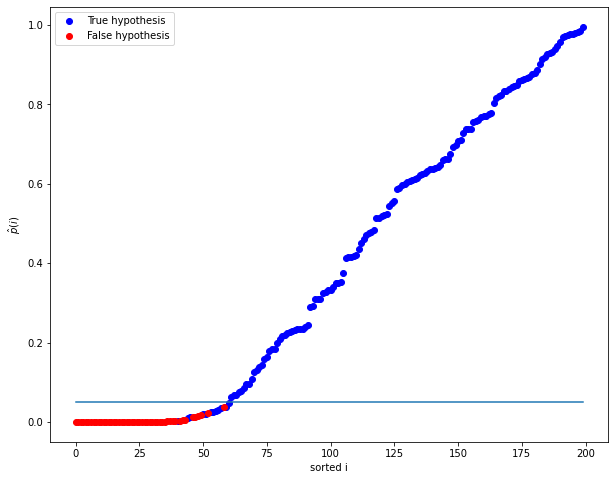

In [33]:
p_values = []
for x in X:
     p_values.append(st.ttest_1samp(x, 0)[1])
        
plot_diff_alpha(p_values, loc_plt=plt)
plt.plot(np.arange(0, m), [0.05]*200)
plt.show()

##### График модифицированых уровней значимости (Bonferroni)

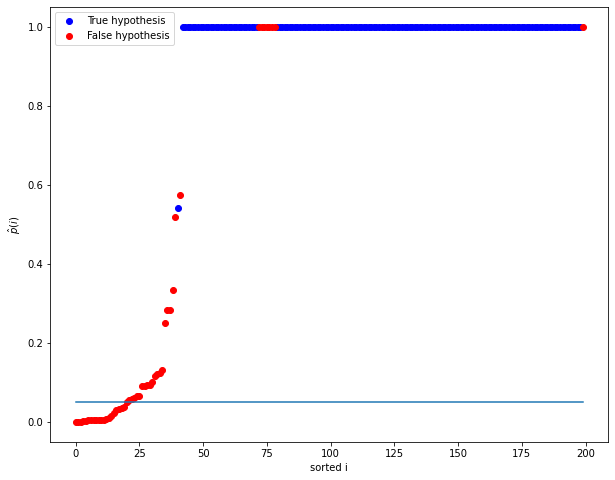

In [35]:
p_values = []
for x in X:
     p_values.append(st.ttest_1samp(x, 0)[1])

p_values = multipletests(p_values, method='bonferroni')[1]

plot_diff_alpha(p_values, loc_plt=plt)
plt.plot(np.arange(0, m), [0.05]*200)
plt.show()

##### График модифицированых уровней значимости (Holm)

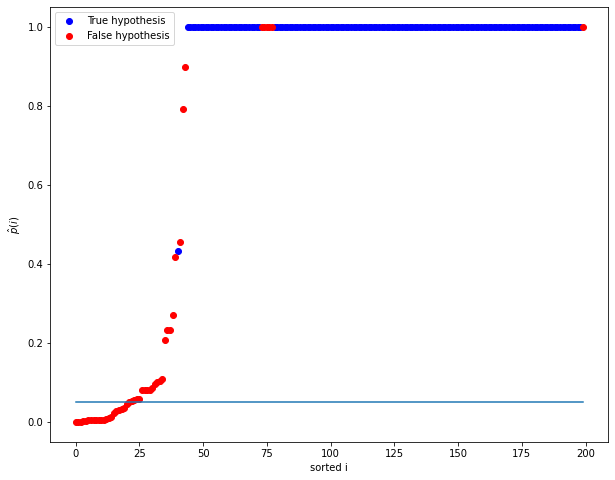

In [36]:
p_values = []
for x in X:
     p_values.append(st.ttest_1samp(x, 0)[1])

p_values = multipletests(p_values, method='holm')[1]

plot_diff_alpha(p_values, loc_plt=plt)
plt.plot(np.arange(0, m), [0.05]*200)
plt.show()

##### График модифицированых уровней значимости (Holm-Sidak)

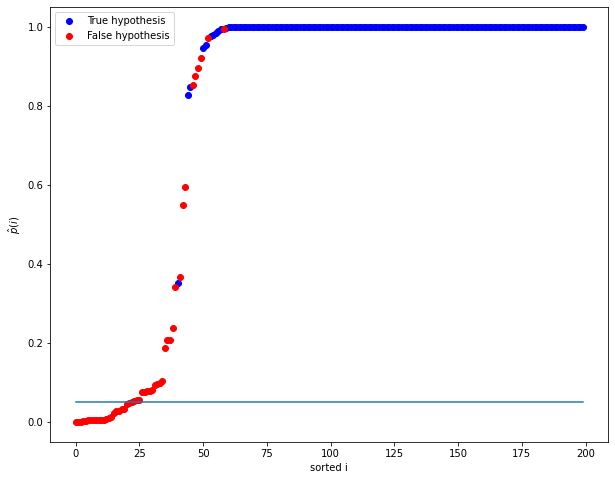

In [38]:
p_values = []
for x in X:
     p_values.append(st.ttest_1samp(x, 0)[1])

p_values = multipletests(p_values, method='holm-sidak')[1]

plot_diff_alpha(p_values, loc_plt=plt)
plt.plot(np.arange(0, m), [0.05]*200)
plt.show()

##### График модифицированых уровней значимости (Benjamini-Hochberg)

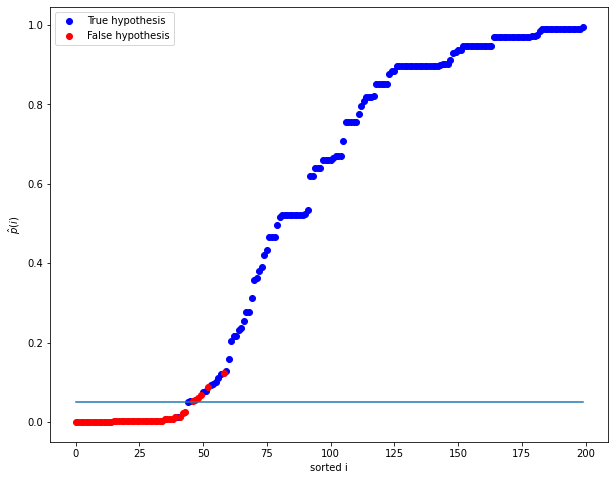

In [40]:
p_values = []
for x in X:
     p_values.append(st.ttest_1samp(x, 0)[1])

p_values = multipletests(p_values, method='fdr_bh')[1]

plot_diff_alpha(p_values, loc_plt=plt)
plt.plot(np.arange(0, m), [0.05]*200)
plt.show()

##### График модифицированых уровней значимости (Benjamini-Yekutieli)

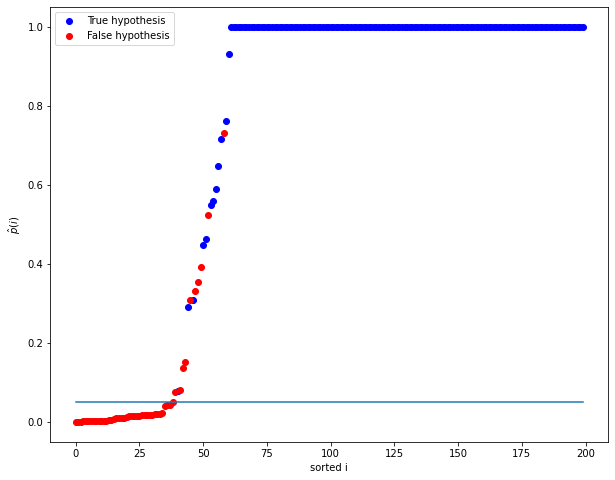

In [41]:
p_values = []
for x in X:
     p_values.append(st.ttest_1samp(x, 0)[1])

p_values = multipletests(p_values, method='fdr_by')[1]

plot_diff_alpha(p_values, loc_plt=plt)
plt.plot(np.arange(0, m), [0.05]*200)
plt.show()

## Лейкоциты и астма

С использованием ДНК-микрочипов были получены анализ изменения генной экспрессии для двух групп детей: больных астмой и здоровых.

Источник данных: http://www.ncbi.nlm.nih.gov/sites/GDSbrowser?acc=GDS4896

### Рассмотрим сами данные

In [42]:
data = pd.read_csv('data/expression.csv', delimiter=';')

In [43]:
data.sample(5)

,ID_REF,IDENTIFIER,Healthy control,Healthy control.1,Healthy control.2,Healthy control.3,Healthy control.4,Healthy control.5,Healthy control.6,Healthy control.7,...,Severe asthma.8,Severe asthma.9,Severe asthma.10,Severe asthma.11,Severe asthma.12,Severe asthma.13,Severe asthma.14,Severe asthma.15,Severe asthma.16,Gene title
24361,8139915,chr7:68972498-68972608,3.76948,3.68015,3.74611,3.63432,3.86040,3.37283,3.71514,3.59223,...,3.78447,4.14862,3.83881,3.67698,3.89037,3.75484,3.81857,3.88641,3.50943,NaN
16236,8153704,SCRT1,5.10719,5.03709,4.88747,4.92006,5.04115,4.96551,5.18758,4.96119,...,5.02194,5.20394,5.05910,5.01995,4.84870,5.04161,4.83771,4.90972,4.63200,scratch family zinc finger 1
1132,8152867,ASAP1,10.77670,10.45790,10.37940,10.30210,10.91190,10.60680,10.68050,10.76900,...,10.47630,10.32990,10.64780,10.58370,11.20130,10.64330,10.27230,10.30870,10.12290,"ArfGAP with SH3 domain, ankyrin repeat and PH ..."
26938,8123763,chr6:6938840-6939130,6.05581,5.85686,5.88777,5.82856,6.04216,5.75013,6.17798,5.81931,...,5.93248,6.04876,5.89860,6.02485,5.92168,5.81926,5.94733,5.77901,6.14720,NaN
18470,8136557,TBXAS1,9.68575,9.63905,9.03147,9.55518,10.21350,9.81557,9.52707,9.85491,...,9.61948,9.77666,9.54023,9.80807,9.96340,10.04780,9.66205,10.08380,9.71226,thromboxane A synthase 1 (platelet)


In [44]:
print('\t\t'.join(list(data.columns)))

ID_REF		IDENTIFIER		Healthy control		Healthy control.1		Healthy control.2		Healthy control.3		Healthy control.4		Healthy control.5		Healthy control.6		Healthy control.7		Healthy control.8		Healthy control.9		Healthy control.10		Healthy control.11		Healthy control.12		Healthy control.13		Healthy control.14		Healthy control.15		Healthy control.16		Healthy control.17		Mild asthma		Mild asthma.1		Mild asthma.2		Mild asthma.3		Mild asthma.4		Mild asthma.5		Mild asthma.6		Mild asthma.7		Mild asthma.8		Mild asthma.9		Mild asthma.10		Mild asthma.11		Mild asthma.12		Mild asthma.13		Mild asthma.14		Mild asthma.15		Mild asthma.16		Mild asthma.17		Mild asthma.18		Severe asthma		Severe asthma.1		Severe asthma.2		Severe asthma.3		Severe asthma.4		Severe asthma.5		Severe asthma.6		Severe asthma.7		Severe asthma.8		Severe asthma.9		Severe asthma.10		Severe asthma.11		Severe asthma.12		Severe asthma.13		Severe asthma.14		Severe asthma.15		Severe asthma.16		Gene title


### Эксперимент

#### Достигаемые уровни значимости в t-Критерии Стьюдента

In [45]:
data_np = data.values
def get_healthy(i):
    '''
    Возвращает всех здоровых пациентов для i-го микрочипа
    '''
    return data_np[i, 2:20]

def get_asthma(i):
    '''
    Возвращает всех больных астмой пациентов для i-го микрочипа
    '''
    return data_np[i, 39:56]

def get_pvalue_t_test(i):
    '''
    Возвращает p-value для критерия Стьюдента для независимых выборок
    '''
    return ttest_ind(get_healthy(i), get_asthma(i), usevar='unequal')[1]
    
p_values = list(map(get_pvalue_t_test, range(data_np.shape[0])))
p_values = np.array(p_values)

#### Модифицированые уровни значимости

In [58]:
p_holm = multipletests(p_values, method='holm')[1]

p_bh = multipletests(p_values, method='fdr_bh')[1]

p_bonferroni = multipletests(p_values, method='bonferroni')[1]

#### Распределения исходных и модифицированных достигаемых уровней значимости

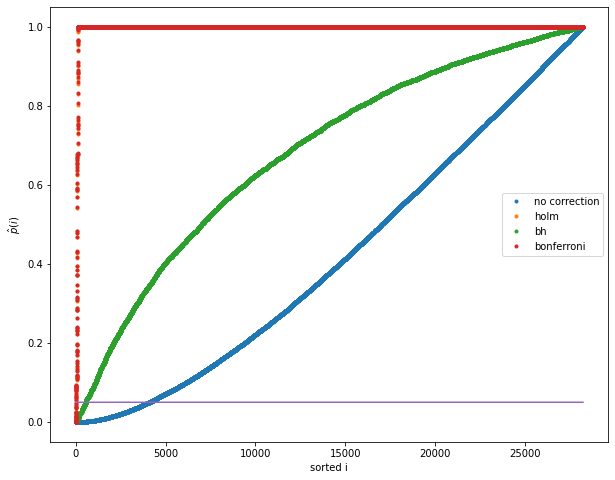

In [59]:
plt.plot(sorted(p_values), '.', label='no correction')
plt.plot(sorted(p_holm), '.', label='holm')
plt.plot(sorted(p_bh), '.', label='bh')
plt.plot(sorted(p_bonferroni), '.', label='bonferroni')
plt.plot(np.arange(0, len(p_bh)), [0.05]*len(p_bh))

plt.xlabel('sorted i')
plt.ylabel('$\hat{p}(i)$')
plt.legend(loc='best')
plt.show()

#### Количество генов, экспрессия которых статистически значимо отличается при поправке методами Холма и Бенджамини-Хохберга:

In [61]:
print('Количество генов, для которых значимо отличается: {}\t(no correction)'.format((p_values <= 0.05).sum()))
print('Количество генов, для которых значимо отличается: {}\t(holm)'.format((p_holm <= 0.05).sum()))
print('Количество генов, для которых значимо отличается: {}\t(bh)'.format((p_bh <= 0.05).sum()))
print('Количество генов, для которых значимо отличается: {}\t(bonferroni)'.format((p_bonferroni <= 0.05).sum()))

Количество генов, для которых значимо отличается: 4087	(no correction)
Количество генов, для которых значимо отличается: 31	(holm)
Количество генов, для которых значимо отличается: 564	(bh)
Количество генов, для которых значимо отличается: 31	(bonferroni)


### На микрочипах есть много проб к малоизученным участкам генома, у которых даже нет названия; их можно сразу удалить из рассмотрения (Эксперимент 2)

In [62]:
reduced_data = data[data['Gene title'].isnull() == False]
reduced_data.shape, data.shape

((21465, 57), (28231, 57))

#### Рассмотрим как изменились уровни значимости

In [63]:
data_np = reduced_data.values

p_values = list(map(get_pvalue_t_test, range(data_np.shape[0])))
p_values = np.array(p_values) 

In [65]:
p_holm = multipletests(p_values, method='holm')[1]

p_bh = multipletests(p_values, method='fdr_bh')[1]

p_bonferroni = multipletests(p_values, method='bonferroni')[1]

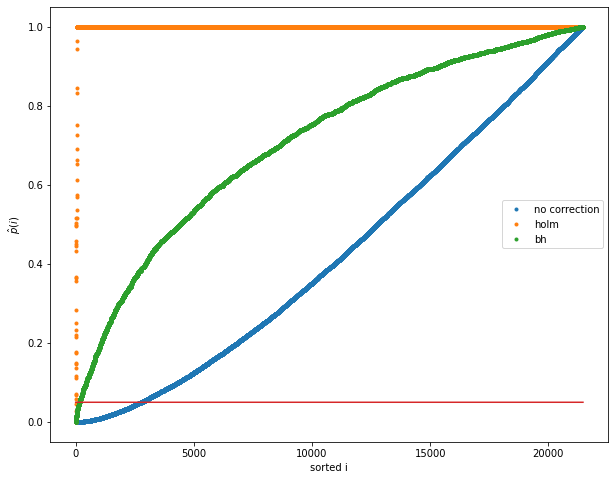

In [66]:
plt.plot(sorted(p_values), '.', label='no correction')
plt.plot(sorted(p_holm), '.', label='holm')
plt.plot(sorted(p_bh), '.', label='bh')
#plt.plot(sorted(p_bonferroni), '.', label='bonferroni')
plt.plot(np.arange(0, len(p_bh)), [0.05]*len(p_bh))

plt.xlabel('sorted i')
plt.ylabel('$\hat{p}(i)$')
plt.legend(loc='best')
plt.show()

In [67]:
print('Количество генов для которых значимо отличается: {}\t(no correction)'.format((p_values <= 0.05).sum()))
print('Количество генов для которых значимо отличается: {}\t(holm)'.format((p_holm <= 0.05).sum()))
print('Количество генов для которых значимо отличается: {}\t(bh)'.format((p_bh <= 0.05).sum()))

Количество генов для которых значимо отличается: 2772	(no correction)
Количество генов для которых значимо отличается: 9	(holm)
Количество генов для которых значимо отличается: 168	(bh)


## Сравнение качества классификаторов

Дано: AUC различных версий алгоритма C4.5, посчитанный на 15 датасетах.

**Demsar J. (2006). Statistical Comparisons of Classifiers over Multiple Data Sets. Journal of Machine Learning Research, 7, 1–30.**

### Рассмотрим данные

In [68]:
data = pd.read_csv('data/auc.txt', delimiter='\t')

In [70]:
data.sample(5)

,Dataset,C4.5,C4.5+m,C4.5+cf,C4.5+m+cf
8,lymphography,0.775,0.838,0.866,0.875
5,iris,0.936,0.931,0.916,0.931
11,rheum,0.619,0.666,0.614,0.669
12,voting,0.972,0.981,0.975,0.975
3,cmc,0.628,0.661,0.654,0.657


In [72]:
data.T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
Dataset,adult (sample),breast cancer,breast cancer wisconsin,cmc,ionosphere,iris,liver disorders,lung cancer,lymphography,mushroom,primary tumor,rheum,voting,wine
C4.5,0.763,0.599,0.954,0.628,0.882,0.936,0.661,0.583,0.775,1,0.94,0.619,0.972,0.957
C4.5+m,0.768,0.591,0.971,0.661,0.888,0.931,0.668,0.583,0.838,1,0.962,0.666,0.981,0.978
C4.5+cf,0.771,0.59,0.968,0.654,0.886,0.916,0.609,0.563,0.866,1,0.965,0.614,0.975,0.946
C4.5+m+cf,0.798,0.569,0.967,0.657,0.898,0.931,0.685,0.625,0.875,1,0.962,0.669,0.975,0.97


### Эксперимент

Между какими из версий есть значимые различия?

Сравним все значения критерия качества попарно с помощью критерия знаковых рангов Уилкоксона (```st.wilcoxon```):

In [74]:
p_values= []
for i in range(1, 5):
    for j in range(i+1, 5):
        test_result = st.wilcoxon(data.iloc[:, i].values, data.iloc[:, j].values, mode='approx')
        p_values += [test_result[1]]        
        print(data.columns[i],data.columns[j], p_values[-1])
                                                                  

C4.5 C4.5+m 0.01075713311978963
C4.5 C4.5+cf 0.861262330095348
C4.5 C4.5+m+cf 0.015906444101703374
C4.5+m C4.5+cf 0.046332729793395394
C4.5+m C4.5+m+cf 0.3278256758446406
C4.5+cf C4.5+m+cf 0.022909099354356588


### Разные поправки

In [79]:
for k in ['bonferroni', 'holm', 'fdr_bh', 'fdr_by']:
    results = multipletests(p_values, method=k)
    print(k)
    print(results[0])
    print(results[1])
    print('#'*80)

bonferroni
[False False False False False False]
[0.0645428  1.         0.09543866 0.27799638 1.         0.1374546 ]
################################################################################
holm
[False False False False False False]
[0.0645428  0.86126233 0.07953222 0.13899819 0.65565135 0.0916364 ]
################################################################################
fdr_bh
[ True False  True False False  True]
[0.0458182  0.86126233 0.0458182  0.06949909 0.39339081 0.0458182 ]
################################################################################
fdr_by
[False False False False False False]
[0.11225459 1.         0.11225459 0.17027278 0.96380749 0.11225459]
################################################################################
